In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
import pickle 
import datetime 
import multiprocessing
import cartopy
import xarray as xr
import os
import sys
#sys.path.append('/mnt/h1/projects/4DGreenland/scripts/lib/')
sys.path.append('/home/annpug/Desktop/annpug/scripts/lib.py')
import lib
import configparser
from osgeo import osr
import glob 
import geopandas as gpd
import seaborn as sns

color_racmo =  (208/255,28/255,31/255)
color_mar = (225/255,126/255,4/255)
color_hirham = (47/255,158/255,49/255) 
colors,categories=lib.getColortableMeltConditions()
ct=((0,'#{:02x}{:02x}{:02x}'.format(*colors.GetColorEntry(0))),
    (1,'#{:02x}{:02x}{:02x}'.format(*colors.GetColorEntry(1))),
    (2,'#{:02x}{:02x}{:02x}'.format(*colors.GetColorEntry(2))),
    (3,'#{:02x}{:02x}{:02x}'.format(*colors.GetColorEntry(3))),
    (4,'#{:02x}{:02x}{:02x}'.format(*colors.GetColorEntry(4))))
labels = ['No melt','Increase of wet snow layer','Wet snow layer','Increase of refrozen layer','stationary']

In [117]:
def open_pickle(file_path): 
    f = open(file_path, 'rb')
    return pickle.load(f)

def read_tif(file_path):
    tif = gdal.Open(file_path)
    band= tif.GetRasterBand(1)
    arr = band.ReadAsArray().astype(np.float64)
    arr[arr == 65535] = np.nan
    return arr 


def icemask_from_tif(file_path):
    '''
    Opens a meltmap (geotif-file) and convert it into a ice mask. Since the extent of the meltmaps are always 
    the same a random melt scene can be used to generate the icemask. Bedrock and ocean are set to np.nan whereas 
    ice is set to 1. 
    
    Input: file_path: Path to meltmap
    Output: icemask: a mask consising of either 1 or nan. 
    '''
    
    icemask = read_tif(file_path)
    # Ocean and bedrock is set to nan. 
    icemask[icemask >= 5] = np.nan
    # Different classes of melt is set to 1 
    icemask[icemask <= 4] = 1
    return icemask 

def number_of_meltdays(rcm, threshold): 
    '''
    Compute the number of meltdays in a year for a RCM. Meltdays are thresholded by a magnitude threshold only. 
    '''    
    melt = np.zeros(rcm.shape)
    #melt = np.full([365, 540, 299], np.nan)
    melt[rcm >= threshold] = 1
    sum_meltdays = np.sum(melt, axis = 0)
    sum_meltdays[sum_meltdays == 0] = np.nan
    return sum_meltdays 

def plot_greenland(data, ax, transform = cartopy.crs.epsg('3413'), mask = None, 
                   vmin = 0, vmax = 100, 
                   cbar = False, cbar_label = None, cmap = 'PuBuGn'): 
    if mask is not None: 
        # Mask data: 
        data = data * mask 
    
    plot = ax.scatter(grid_X, grid_Y, c = np.flip(data, axis =0 ), 
               transform = transform, s = 0.5, cmap = cmap, 
               vmin = vmin, vmax = vmax)
    ax.add_feature(cartopy.feature.LAND,color = 'tan', alpha = 0.7)
    ax.coastlines(resolution='50m', linewidth = 0.1)
    if cbar:
        plt.colorbar(plot , ax = ax , label = cbar_label)
        
def rolling_window(a, size):
    '''
    Takes an array (1D or 2D) and compute an array using a rolling window (2D or 3D array). The rollig array is 
    created along the first axis (i.e. time). 
    
    Input: a: The original array that the rolling array needs to be computed from. 
           size: size of the rolling window. 
    
    Output: The rolling window array. 
    '''
    
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a.strides[-1],)
    
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def find_first_last(arr):
    '''
    Takes a 3D boolean array and finds the first and last occurence of True along the zero axis (time in this case).
    
    Input: arr: 3D boolean array
    Output: first_occurrence: The index of the first True occurence. 
            last_occurence: The index of the last True occurance
    '''
    
    # Find the index of the first occurence:  
    first_occurrence = np.argmax(arr, axis=0)
    # Flip array around and find the last occurence. Since the index correspond to the flipped array, substract 
    # with the size of array: 
    last_occurrence = arr.shape[0] - np.argmax(np.flip(arr, axis=0), axis=0) - 1
    return first_occurrence.astype(np.float32),  last_occurrence.astype(np.float32)


def melt_season(array, thresholds, length):
    
    '''
    
    
    '''
    
    outarray = np.zeros_like(array).astype('bool')
    subarray1 = np.ones(length) * thresholds[0]
    subarray2 = np.ones(length) * thresholds[1]
    index1 = np.all(rolling_window(array, length) >= subarray1, axis=2)
    index2 = np.all(rolling_window(array, length) <= subarray2, axis=2)
    index = index1 & index2
    outarray[:, :index.shape[1]] = index
    #print(outarray)
    # now get start and end: 
    start, end = find_first_last(outarray.T)
    start[start == 0] = np.nan
    start = start.reshape((540,299))
    end[end >= 364] = np.nan
    end = end.reshape((540,299))
    end = end + 2
    return start, end

def world_to_pixel( geo_matrix, x1, y1,out_epsg):
    from pyproj import Proj, Transformer

    # tranform to polar sterographic:
    transformer = Transformer.from_crs('EPSG:4326',out_epsg)  
    x2,y2 = transformer.transform(y1,x1)

    # Get pixels:
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = int((x2 - ul_x) / x_dist)
    line = -int((ul_y - y2) / y_dist)
    return pixel, line

def rolling_window_rcm(array, threshold, length):
    outarray = np.zeros_like(array).astype('bool')
    subarray = np.ones(length) * threshold
    index = np.any(rolling_window(array, length) >= subarray, axis=2)
    outarray[:, :index.shape[1]] = index
    return outarray.T

def window_comparion(ascat, rcm, threshold, length): 
    
    '''
    Compute find the ratio (procentage) between days with melt/refreezing/no melt in both ASCAT and RCM 
    and total number of days with melt/refreezing/no melt in ASCAT. It is possible to specify a window in which 
    the RCM "looks into the future" using the length variable. If length = 1, no window is applied. 
    
    Input: ascat: Boolean-like that specifies if selected ascat claasification is satisfied. 
           rcm: RCM with daily active melt. 
           threshold: Threshold for when a day is clssified as a melt day in the RCM. 
           length: The number of days in the future included in the RCM used to account for the preporsseing 
                   window of ASCAT. If length = 1, no window is applied. 
    
    Output: The melt/refreezing/no melt ratio for each pixel in the ascat grid. Pixels where melt/refreezing/no melt
            is not detecetd by ASCAT is set to nan. 
    '''
    
    # Computed boolean array melt occurs over a threshold inside a window of specified length: 
    window_rcm = rolling_window_rcm(rcm.reshape((rcm.shape[0], -1)).T,threshold, length)
    melt_rcm = window_rcm.reshape(rcm.shape) # reshape into original dimentions to match ASCAT 
    
    # Days where 
    match = np.equal(ascat.astype('bool'), melt_rcm).astype('float')
    # Exclude indexs where ASCAT is False: 
    match[ascat == 0] = np.nan
    # Sum days: 
    sum_match = np.nansum(match, axis = 0)
    sum_ascat = np.nansum(ascat, axis = 0)
    return np.divide(sum_melt_match,sum_ascat)*100 # Computed ratio. 

# Choose year and import RCMs

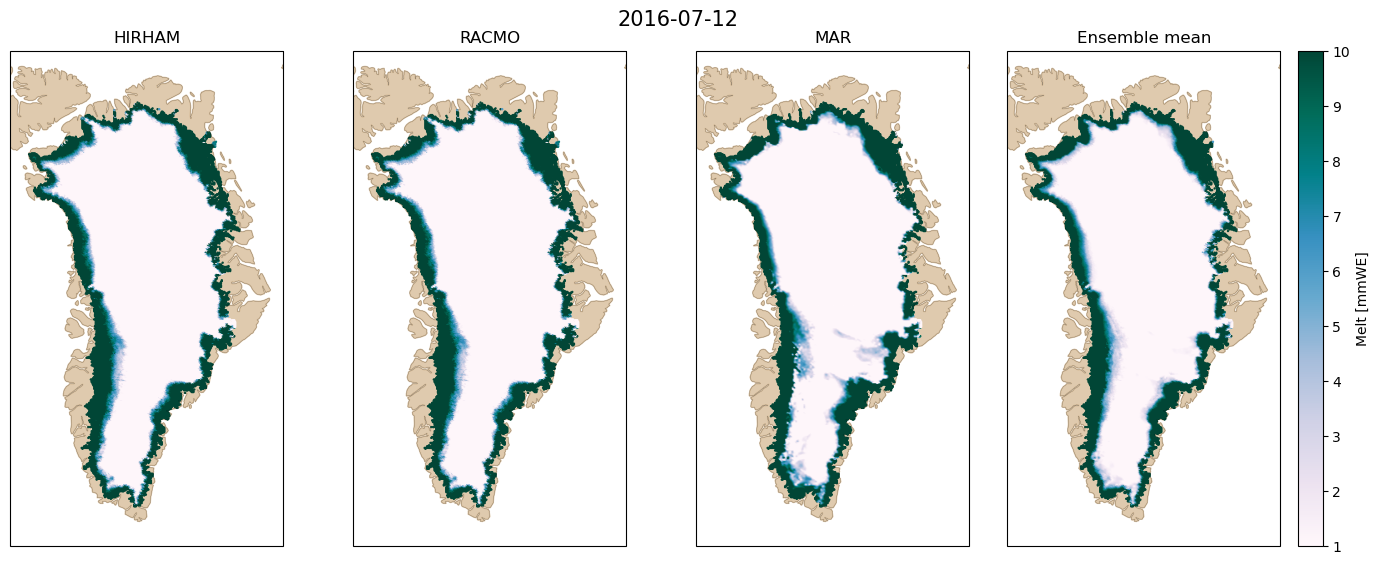

In [140]:
year = 2016

# Load in regridded RCMs:
hirham = open_pickle(f'/home/annpug/Desktop/annpug/regriddedRCM/HIRHAM_{year}_regridded_nearest.pkl')
racmo = open_pickle(f'/home/annpug/Desktop/annpug/regriddedRCM/RACMO_{year}_regridded_nearest.pkl')
mar = open_pickle(f'/home/annpug/Desktop/annpug/regriddedRCM/MAR_{year}_regridded_cubic.pkl')

# create ensemble mean:
ens = np.stack((hirham,racmo,mar), axis=-1)
ens_mean = np.mean(ens, axis = 3)

# load a random scene and convert it to the an icemask: 
ascat_mask = icemask_from_tif('/mnt/h1/projects/4DGreenland/meltmap_v01/ASCAT/2018/meltmap_2018-09-24.tif')

# Load grid; 
grid = xr.open_dataset('/home/annpug/Desktop/annpug/tif_grid.nc')
grid_X, grid_Y = np.meshgrid(grid.x,grid.y)



# Compute number of melt days for RCMs 

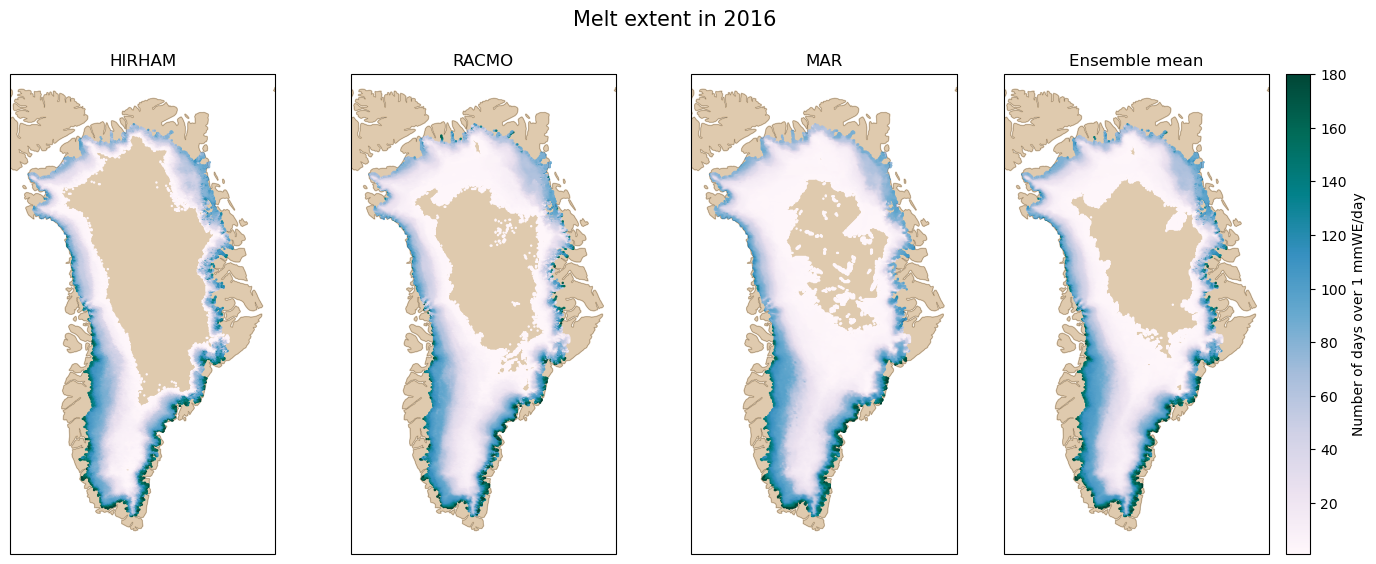

In [141]:
# Compute the number of days where melt is over one threshold:
threshold = 1
meltdays_racmo = number_of_meltdays(racmo,threshold)
meltdays_hirham = number_of_meltdays(hirham,threshold)
meltdays_mar = number_of_meltdays(mar,threshold)
meltdays_ens = number_of_meltdays(ens_mean,threshold)

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Melt extent in {year}\n\n', fontsize = 15)
plot_greenland(meltdays_hirham, axs[0], crs_epsg, mask = ascat_mask, vmin = 1, vmax = 180)
axs[0].set_title('HIRHAM')
plot_greenland(meltdays_racmo, axs[1], crs_epsg,  mask = ascat_mask, vmin = 1, vmax = 180)
axs[1].set_title('RACMO')
plot_greenland(meltdays_mar, axs[2], crs_epsg,  mask = ascat_mask,  vmin = 1, vmax = 180)
axs[2].set_title('MAR')
plot_greenland(meltdays_ens, axs[3], crs_epsg,  mask = ascat_mask, cbar = True,  
               cbar_label = f'Number of days over {threshold} mmWE/day', 
               vmin = 1, vmax = 180)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

# Compute onset, end and duration of melt season for RCM

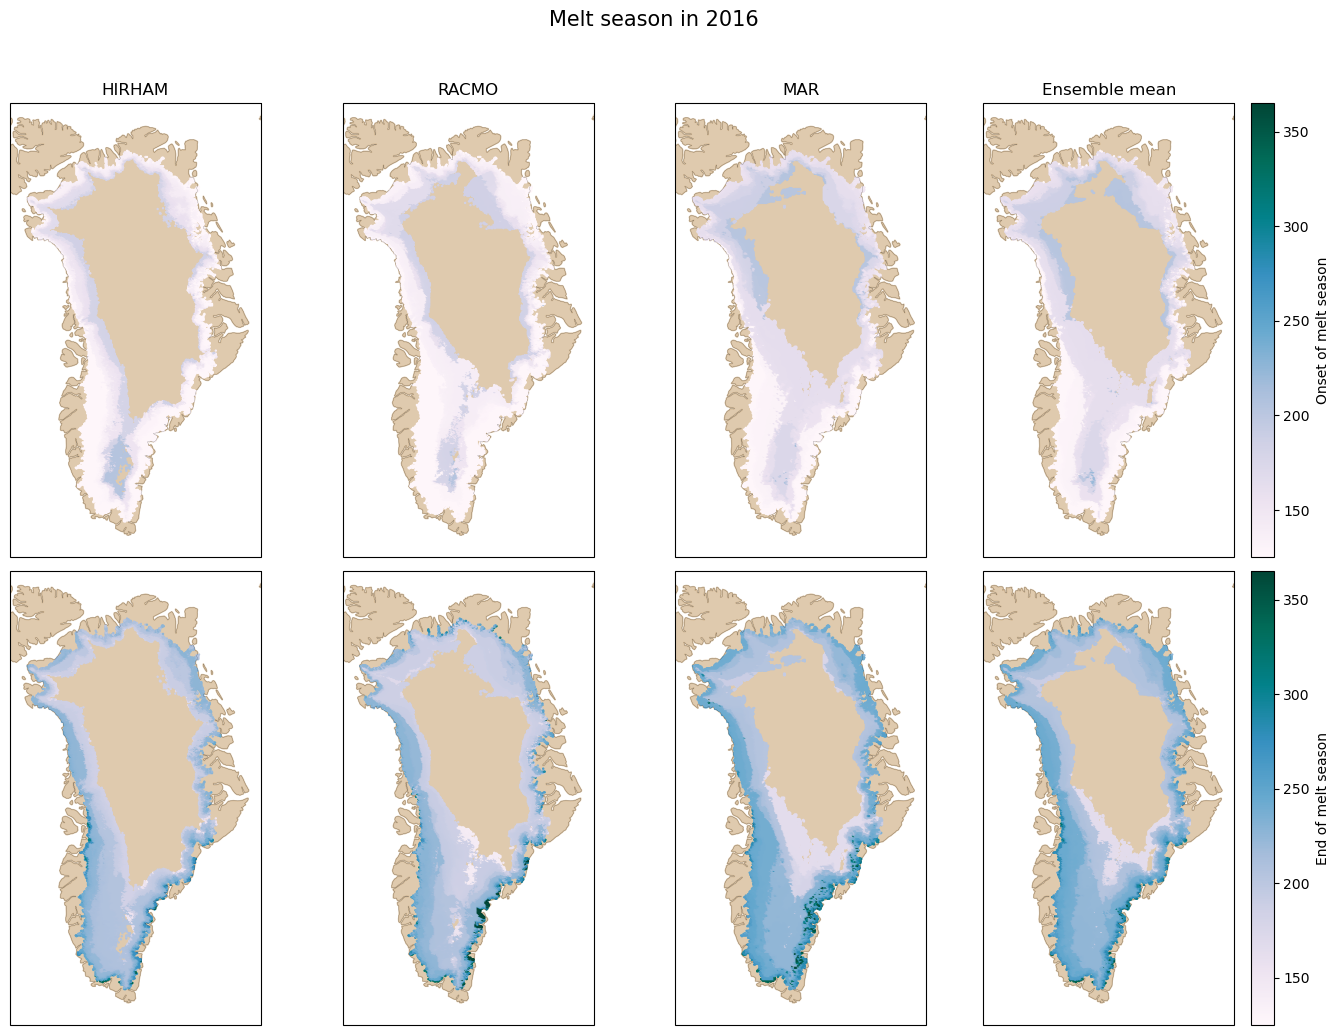

In [142]:
len_threshold = 3
magn_threshold = [0.5, 1000] # 1000 
# Compute start and end of melt season for each RCM;  
start_racmo, end_racmo = get_melt_state(racmo.reshape((racmo.shape[0], -1)).T, magn_threshold, len_threshold)
start_hirham, end_hirham = get_melt_state(hirham.reshape((hirham.shape[0], -1)).T, magn_threshold, len_threshold)
start_mar, end_mar = get_melt_state(mar.reshape((mar.shape[0], -1)).T, magn_threshold, len_threshold)
start_ens, end_ens = get_melt_state(ens_mean.reshape((ens_mean.shape[0], -1)).T, magn_threshold, len_threshold)

# Plot
fig, axs = plt.subplots(2, 4, figsize = (14,10.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Melt season in {year}\n\n', fontsize = 15)
plot_greenland(start_hirham, axs[0,0], crs_epsg, mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(end_hirham, axs[1,0], crs_epsg, mask = ascat_mask, vmin = 150, vmax = 365)
axs[0,0].set_title('HIRHAM')
plot_greenland(start_racmo, axs[0,1], crs_epsg,  mask = ascat_mask, vmin = 150, vmax = 365)
plot_greenland(end_racmo, axs[1,1], crs_epsg,  mask = ascat_mask, vmin = 150, vmax = 365)

axs[0,1].set_title('RACMO')
plot_greenland(start_mar, axs[0,2], crs_epsg,  mask = ascat_mask,  vmin = 125, vmax = 365)
plot_greenland(end_mar, axs[1,2], crs_epsg,  mask = ascat_mask,  vmin = 125, vmax = 365)
axs[0,2].set_title('MAR')
plot_greenland(start_ens, axs[0,3], crs_epsg,  mask = ascat_mask, cbar = True,  
               cbar_label = f'Onset of melt season', 
               vmin = 125, vmax = 365)
plot_greenland(end_ens, axs[1,3], crs_epsg,  mask = ascat_mask, cbar = True,  
               cbar_label = f'End of melt season', 
               vmin = 125, vmax = 365)
axs[0,3].set_title('Ensemble mean')
fig.tight_layout(pad = 1)
plt.show()

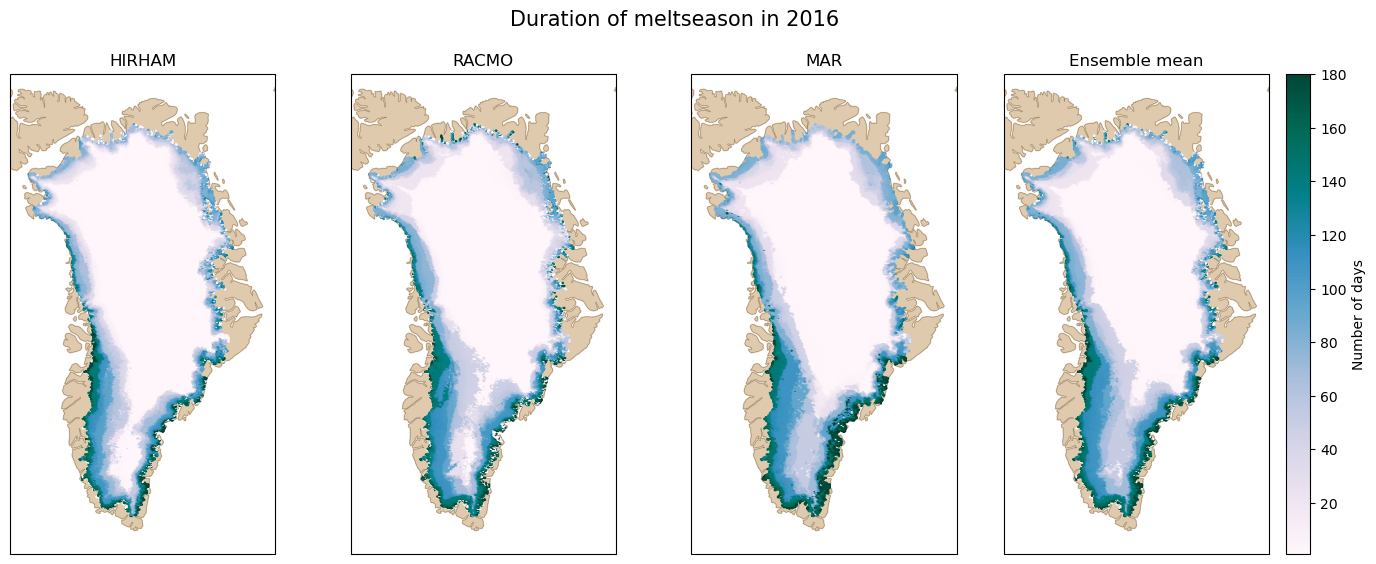

In [143]:
duration_hirham = end_hirham - start_hirham
duration_racmo = end_racmo - start_racmo
duration_mar = end_mar - start_mar
duration_ens = end_ens - start_ens
duration_hirham[(duration_hirham.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_racmo[(duration_racmo.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_mar[(duration_mar.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0
duration_ens[(duration_ens.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0


# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Duration of meltseason in {year}\n\n', fontsize = 15)
plot_greenland(duration_hirham, axs[0], crs_epsg, mask = ascat_mask, vmin = 1, vmax = 180)
axs[0].set_title('HIRHAM')
plot_greenland(duration_racmo, axs[1], crs_epsg,  mask = ascat_mask, vmin = 1, vmax = 180)
axs[1].set_title('RACMO')
plot_greenland(duration_mar, axs[2], crs_epsg,  mask = ascat_mask,  vmin = 1, vmax = 180)
axs[2].set_title('MAR')
plot_greenland(duration_ens, axs[3], crs_epsg,  mask = ascat_mask, cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 180)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()


# Load ASCAT to compute the melt season and compute differences between RCM 

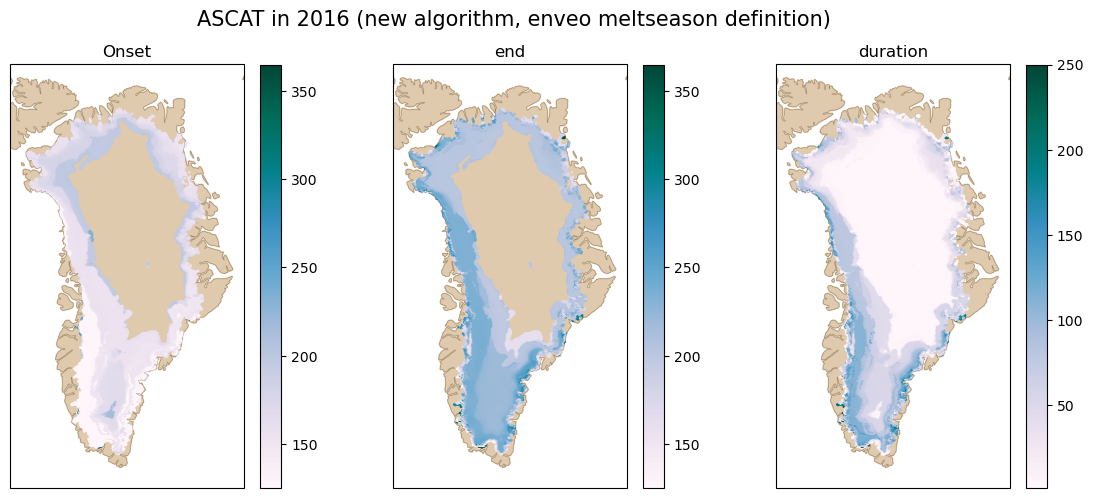

In [144]:
ascat = []
dates_ascat = pd.date_range(datetime.date(year,1, 1), periods = racmo.shape[0])
for date in dates_ascat: 
    date_str = date.strftime('%Y-%m-%d')
    file = glob.glob(f'/mnt/h1/projects/4DGreenland/meltmap_v01/ASCAT/{year}/meltmap_{date_str}.tif')
    #file = glob.glob(f'/mnt/h1/projects/4DGreenland/meltmap_v02/ASCAT/meltmap_v02_{date_str}.tif')
    #print(file)
    # if there is no file then make it completely no melt: (so only winter days missing (except 2019)) 
    if len(file) == 0: 
        tif = ascat_mask
        tif[tif == 1] = 0
    # if there is a file then open it: 
    else: 
        tif = read_tif(file[0])
        tif[tif >= 5] = np.nan
    
    ascat.append(tif)    
    
ascat = np.array(ascat)  

# Save as pickle:
#with open(f'/home/annpug/Desktop/annpug/ascat_{year}.pkl','wb') as f:
#    pickle.dump(ascat, f)

# Melt season begins when the next three days also have melt and ends with the last 3 days of refree: 
#ascat_threshold = 5
onset_ascat, end_ascat = get_melt_state(ascat.reshape((ascat.shape[0], -1)).T, [0.9, 2.1], 3)
_, end_ascat = get_melt_state(ascat.reshape((ascat.shape[0], -1)).T, [0.9, 2.1], 3)

#duration_ascat = end_ascat - onset_ascat

# Plot
fig, axs = plt.subplots(1, 3, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})

duration_ascat = end_ascat - onset_ascat
duration_ascat[(duration_ascat.astype(str)==str(np.nan)) & (ascat_mask.astype(str) != str(np.nan)) ] = 0

fig.suptitle(f'ASCAT in {year} (new algorithm, enveo meltseason definition)\n', fontsize = 15)
plot_greenland(onset_ascat, axs[0], crs_epsg, vmin = 125, vmax = 365, cbar = True )
axs[0].set_title('Onset')
plot_greenland(end_ascat , axs[1], crs_epsg, vmin = 125, vmax = 365, cbar = True)
axs[1].set_title('end')
plot_greenland(duration_ascat, axs[2], crs_epsg, vmin = 1, vmax = 250, cbar = True)
axs[2].set_title('duration')
plt.show()

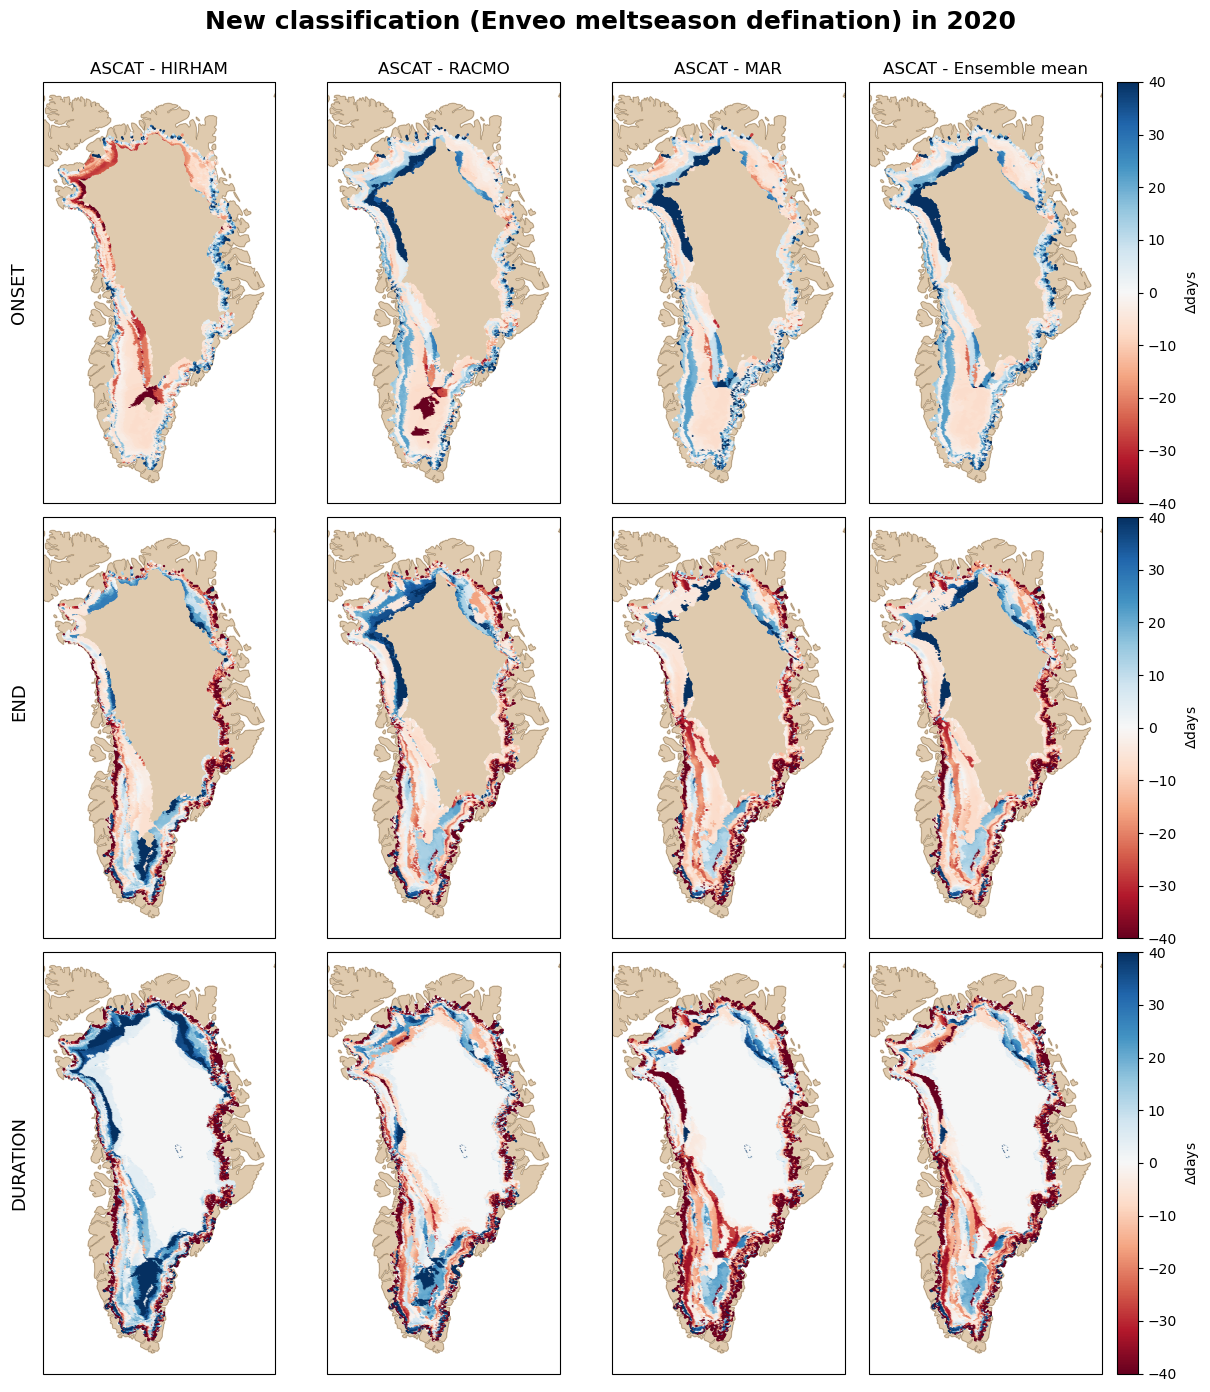

In [84]:
# hirham 
onset_dif_hirham = onset_ascat- start_hirham
end_dif_hirham = end_ascat - end_hirham
duration_dif_hirham = duration_ascat - duration_hirham
# racmo 
onset_dif_racmo = onset_ascat - start_racmo
end_dif_racmo = end_ascat - end_racmo
duration_dif_racmo = duration_ascat - duration_racmo 
# mar
onset_dif_mar = onset_ascat - start_mar
end_dif_mar = end_ascat - end_mar
duration_dif_mar = duration_ascat- duration_mar 
# ensemble mean 
onset_dif_ens = onset_ascat - start_ens
end_dif_ens = end_ascat - end_ens
duration_dif_ens = duration_ascat - duration_ens

cmap = 'RdBu'
minlim = -40
maxlim = 40
# Plot
fig, axs = plt.subplots(3, 4, figsize = (12,14), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'New classification (Enveo meltseason defination) in {year}\n\n', fontsize = 18, fontweight = 'bold')
# Hirham 
plot_greenland(onset_dif_hirham, axs[0,0], crs_epsg, vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_hirham, axs[1,0], crs_epsg , vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_hirham, axs[2,0], crs_epsg , vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,0].set_title('ASCAT - HIRHAM')
axs[0,1].set_ylabel('ONSET')
axs[1,1].set_ylabel('END')
axs[2,1].set_ylabel('DURATION')
# racmo 
plot_greenland(onset_dif_racmo, axs[0,1], crs_epsg, vmin =minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_racmo, axs[1,1], crs_epsg , vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_racmo, axs[2,1], crs_epsg , vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,1].set_title('ASCAT - RACMO')
# mar 
plot_greenland(onset_dif_mar, axs[0,2], crs_epsg,  vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_mar, axs[1,2], crs_epsg,  vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_mar, axs[2,2], crs_epsg,  vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,2].set_title('ASCAT - MAR')
# ensembel mean 
plot_greenland(onset_dif_ens, axs[0,3], crs_epsg, cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_ens, axs[1,3], crs_epsg, cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_ens, axs[2,3], crs_epsg, cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)
axs[0,3].set_title('ASCAT - Ensemble mean')
plt.figtext(-0, 0.8, 'ONSET', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.5, 'END', ha='left', va='top', rotation = 'vertical', fontsize =13)
plt.figtext(-0, 0.19, 'DURATION', ha='left', va='top', rotation = 'vertical', fontsize =13)
fig.tight_layout(pad = 0)
plt.show()

# Create table with characteritics (Not ready)

In [9]:
mean_onset_hirham = np.nanmean(start_hirham)
mean_end_hirham = np.nanmean(end_hirham)
mean_duration_hirham = np.nanmean(duration_hirham)

mean_onset_racmo = np.nanmean(start_racmo)
mean_end_racmo = np.nanmean(end_racmo)
mean_duration_racmo = np.nanmean(duration_racmo)

mean_onset_mar = np.nanmean(start_mar)
mean_end_mar = np.nanmean(end_mar)
mean_duration_mar = np.nanmean(duration_mar)

mean_onset_ens = np.nanmean(start_ens)
mean_end_ens = np.nanmean(end_dif_ens)
mean_duration_ens = np.nanmean(duration_dif_ens)


data4tab1 = [#["Data type","Mean onset difference","Mean end difference", "Mean duration difference"],
         ["HIRHAM",mean_onset_hirham,mean_end_hirham, mean_duration_hirham],
         ["RACMO",mean_onset_racmo,mean_end_racmo, mean_duration_racmo],
         ["MAR",mean_diff_onset_mar,mean_diff_end_mar, mean_diff_duration_mar], 
         ["Ensemble mean",mean_diff_onset_ens,mean_diff_end_ens, mean_diff_duration_ens]]
table = tabulate.tabulate(data4tab1, tablefmt='html', floatfmt=".1f", headers = ["Data set","Mean onset ","Mean end ", "Mean duration"])
table

NameError: name 'mean_diff_onset_mar' is not defined

In [9]:
mean_diff_onset_hirham = np.nanmean(onset_dif_hirham)
mean_diff_end_hirham = np.nanmean(end_dif_hirham)
mean_diff_duration_hirham = np.nanmean(duration_dif_hirham)

mean_diff_onset_racmo = np.nanmean(onset_dif_racmo)
mean_diff_end_racmo = np.nanmean(end_dif_racmo)
mean_diff_duration_racmo = np.nanmean(duration_dif_racmo)

mean_diff_onset_mar = np.nanmean(onset_dif_mar)
mean_diff_end_mar = np.nanmean(end_dif_mar)
mean_diff_duration_mar = np.nanmean(duration_dif_mar)

mean_diff_onset_ens = np.nanmean(onset_dif_ens)
mean_diff_end_ens = np.nanmean(end_dif_ens)
mean_diff_duration_ens = np.nanmean(duration_dif_ens)

import tabulate

data = [#["Data type","Mean onset difference","Mean end difference", "Mean duration difference"],
         ["ASCAT - HIRHAM",mean_diff_onset_hirham,mean_diff_end_hirham, mean_diff_duration_hirham],
         ["ASCAT - RACMO",mean_diff_onset_racmo,mean_diff_end_racmo, mean_diff_duration_racmo],
         ["ASCAT - MAR",mean_diff_onset_mar,mean_diff_end_mar, mean_diff_duration_mar], 
         ["ASCAT - Ensemble mean",mean_diff_onset_ens,mean_diff_end_ens, mean_diff_duration_ens]]
table = tabulate.tabulate(data, tablefmt='html', floatfmt=".1f", headers = ["Data set","Mean onset difference","Mean end difference", "Mean duration difference"])
table


'<table>\n<thead>\n<tr><th>Data set             </th><th style="text-align: right;">  Mean onset difference</th><th style="text-align: right;">  Mean end difference</th><th style="text-align: right;">  Mean duration difference</th></tr>\n</thead>\n<tbody>\n<tr><td>ASCAT - HIRHAM       </td><td style="text-align: right;">                  -13.2</td><td style="text-align: right;">                 22.7</td><td style="text-align: right;">                      35.2</td></tr>\n<tr><td>ASCAT - RACMO        </td><td style="text-align: right;">                   -5.2</td><td style="text-align: right;">                 18.3</td><td style="text-align: right;">                      24.4</td></tr>\n<tr><td>ASCAT - MAR          </td><td style="text-align: right;">                   -2.8</td><td style="text-align: right;">                 18.7</td><td style="text-align: right;">                      21.6</td></tr>\n<tr><td>ASCAT - Ensemble mean</td><td style="text-align: right;">                   -3.2</td><td style="text-align: right;">                 17.8</td><td style="text-align: right;">                      21.3</td></tr>\n</tbody>\n</table>'

In [85]:
# MAKE TABLE
ds = gdal.Open('/mnt/h1/projects/4DGreenland/meltmap_v02/ASCAT/meltmap_v02_2016-01-02.tif')

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)
    
model = 'ens'
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_end_{year}.tif", end_dif_ens, ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_onset_{year}.tif", onset_dif_ens, ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_{model}_duration_{year}.tif", duration_dif_ens, ds)

# Backscatter profiles  

In [12]:
confpath = '/mnt/h1/projects/4DGreenland/scripts/4DGreenland_ASCAT_meltmap.ini'
config = configparser.ConfigParser()
config.read(confpath)

root_dir=config['PROJECT']['root_dir'].rstrip('/')
project=config['PROJECT']['project'].rstrip('/')
product_type='npy'
prj=config['PROJECT']['project']
sensor=config['DATA']['sensor']
timespan = f'{year}002_{year}362'
ipath=os.path.join(root_dir,project,product_type+'/')
opf = os.path.join(ipath,prj+'_'+sensor+'_'+timespan+'_data.npy')
metadict=lib.readYaml(os.path.join(ipath,prj+'_'+sensor+'_'+timespan+'_meta.yml'))
data = np.memmap(opf,dtype=np.dtype(metadict['dtype']), mode='r', shape=tuple(metadict['shape']))
filelist = np.load(ipath+prj+'_'+sensor+'_'+timespan+'_filelist.npy',allow_pickle=True)
mask = np.load(ipath+prj+'_'+sensor+'_'+timespan+'_mask.npy')
dates,vrtlist=list(zip(*filelist))

ds = gdal.Open('/mnt/h1/projects/4DGreenland/meltmap_v02/ASCAT/meltmap_v02_2015-01-15.tif')
geo_matrix = ds.GetGeoTransform()
proj = osr.SpatialReference(wkt=ds.GetProjection())
out_epsg='EPSG:'+str(proj.GetAttrValue('AUTHORITY',1))
ds=None

In [13]:
st = 'NASA-SE'

if len(st) > 5:
    aws_measurements = pd.read_csv(f'/home/annpug/Desktop/annpug/AWS/combined/day/{st}_day.csv', header = 14, skipinitialspace=True, skiprows = range(15,25))
    aws_measurements = aws_measurements.rename(columns ={'# fields = timestamp': 'time', 'TA1':'t_u',
                                                        'Lat':'gps_lat', 'Lon':'gps_lon'})
    aws_measurements = aws_measurements.set_index('time')
    
# Load measurements from AWS
else: 
    aws_measurements = pd.read_csv(f'/home/annpug/Desktop/annpug/AWS/PROMICE/day/{st}_day.csv')
    aws_measurements = aws_measurements.set_index('time')

year_aws_measurements = aws_measurements.loc[f'{year}-01-01':f'{year}-12-31']
awsDates = pd.to_datetime(year_aws_measurements.index)# get station>
airTemp = year_aws_measurements.t_u

# Get longitud and latitude:
st_lat = year_aws_measurements.gps_lat[0]
st_lon = year_aws_measurements.gps_lon[0]

# Used to transfrom into polar stereographic:
#transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:3413')

x1,y1=world_to_pixel( geo_matrix, st_lon,st_lat,out_epsg) #'epsg:3413')
#x1=210
#y1=98

dates_class, year_ASCAT, doys,res = lib.classify(data[:,y1,x1],dates,config['PROCESSING'])
dates=np.asarray(dates)

point_mar = mar[:, y1,x1]
point_hirham = hirham[:,y1,x1]
point_racmo = racmo[:,y1,x1]
point_ens = ens_mean[:,y1,x1]
dates_rcm = pd.date_range(datetime.date(year,1, 1), periods = racmo.shape[0])

In [11]:
ascat_season = [dates_rcm[int(onset_ascat[y1, x1])], dates_rcm[int(end_ascat[y1, x1])]]
hirham_season = [dates_rcm[int(start_hirham[y1, x1])], dates_rcm[int(end_hirham[y1, x1])]]
racmo_season = [dates_rcm[int(start_racmo[y1, x1])], dates_rcm[int(end_racmo[y1, x1])]]
mar_season = [dates_rcm[int(start_mar[y1, x1])], dates_rcm[int(end_mar[y1, x1])]]
ens_season = [dates_rcm[int(start_ens[y1, x1])], dates_rcm[int(end_ens[y1, x1])]]

plotTemperature = True
font= {'fontname':'Arial'}
labelfont = {'fontsize':14, **font}
tickfont = {'labelsize':10, **font}


fig, ax = plt.subplots(1,figsize=(18, 6))
for i,j in ct:
    z=0
    for k in dates_class[np.array(res==i)]:
        ax.axvspan(k,k +  np.timedelta64(24,'h'), facecolor=j, alpha=0.8,label=labels[i] if z == 0 else "")
        z+=1

ax.set_ylim([-15, 15])
#dateind=(dates>=datelims[0])&(dates<=datelims[1])
#ax.set_xlim(datelims)
#ax.plot(ASCAT_onset,0, '>', color = 'black', markersize=8)
#ax.plot(ASCAT_end,0, '>', color = 'black', markersize=8)
ax.plot(dates,data[:,y1,x1],'k-', label = 'ASCAT') #,label=f'lat {lat} lon {lon}')
ax.tick_params(labelsize=12)
ax.set_xlabel('date',**labelfont)
#fmt_month = mdates.MonthLocator()
#ax.xaxis.set_minor_locator(fmt_month)
ax.set_ylabel('Backscatter [dB]',**labelfont)

# ax[0].legend(loc="lower right")
if plotTemperature == True:
    axr = ax.twinx()
    #axr.plot(awsDates,airTemp,color='#1f78b4', label = 'PROMICE Ts')
    #racmo.melt.plot(ax=axr, color =color_racmo, label = 'RACMO', linewidth = 0.8)
    #mar.melt.plot(ax=axr, color = color_mar, label = 'MAR', linewidth = 0.8)
    plt.plot(dates_rcm, point_hirham, color =color_hirham, label = 'HIRHAM', linewidth = 0.8)
    plt.plot(dates_rcm, point_mar, color =color_mar, label = 'MAR', linewidth = 0.8)
    plt.plot(dates_rcm, point_racmo, color =color_racmo, label = 'RACMO', linewidth = 0.8)
    plt.plot(dates_rcm, point_ens, color ='purple', label = 'Ensemble mean', linewidth = 0.8)
    # Start and end of melt season in RCMs:
    #plt.plot(hirham_season, [0,0], '<', color = color_hirham )
    plt.plot(mar_season, [0,0], '<', color = color_mar)
    plt.plot(racmo_season, [0,0], '<', color = color_racmo)
    plt.plot(ens_season, [0,0], '<', color = 'purple')
    
    plt.plot(ascat_season, [0,0], '<', color = 'black')
    #plt.plot(dates_rcm[int(start_mar[y1, x1])],0, 'o',markersize=8, color = color_mar)
    #axr.plot([racmo_onset, racmo_end], [0,0], '<',markersize=8, color = color_racmo)
    axr.set_ylabel('Air Temperature [°C] or RCMs melt [mmWE/day]', **labelfont)
    axr.set_xlim(dates_rcm[0], dates_rcm[-1])
    axr.set_ylim([-15,10])
    #axr.set_title(f'Timeseries at point 1 {year}')
else: 
    ax.set_title(f'Timeseries at AWS {aws} {year}')

ax1_ylims = ax.axes.get_ylim()           # Find y-axis limits set by the plotter
ax1_yratio = float(ax1_ylims[0] / ax1_ylims[1])  # Calculate ratio of lowest limit to highest limit
ax2_ylims = axr.axes.get_ylim()           # Find y-axis limits set by the plotter
ax2_yratio = float(ax2_ylims[0] / ax2_ylims[1])  # Calculate ratio of lowest limit to highest limit
#ax.plot([dates[0],dates[-1]],[0,0],'k--') #,label=f'lat {lat} lon {lon}')

if ax1_yratio < ax2_yratio: 
    axr.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
else:
    ax.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
#fig.savefig(f'/home/annpug/Desktop/annpug/figures/point1_ASCAT_RCM_AWS_{year}.png')



NameError: name 'onset_ascat' is not defined

# SOMETHING ABOUT POINTS FROM QGIS





No start/end for Hirham for point 1
No start/end for Racmo for point 1
No start/end for Mar for point 1
No start/end for Ensemble mean for point 0
No start/end for Hirham for point 2
No start/end for Racmo for point 2
No start/end for Mar for point 2
No start/end for Ensemble mean for point 1
No start/end for Hirham for point 3
No start/end for Racmo for point 3
No start/end for Mar for point 3
No start/end for Ensemble mean for point 2
No start/end for Hirham for point 4
No start/end for Racmo for point 4
No start/end for Mar for point 4
No start/end for Ensemble mean for point 3
No start/end for Hirham for point 5
No start/end for Racmo for point 5
No start/end for Mar for point 5
No start/end for Ensemble mean for point 4
No start/end for Hirham for point 6
No start/end for Racmo for point 6
No start/end for Mar for point 6
No start/end for Ensemble mean for point 5
No start/end for Hirham for point 7
No start/end for Racmo for point 7
No start/end for Mar for point 7
No start/end f

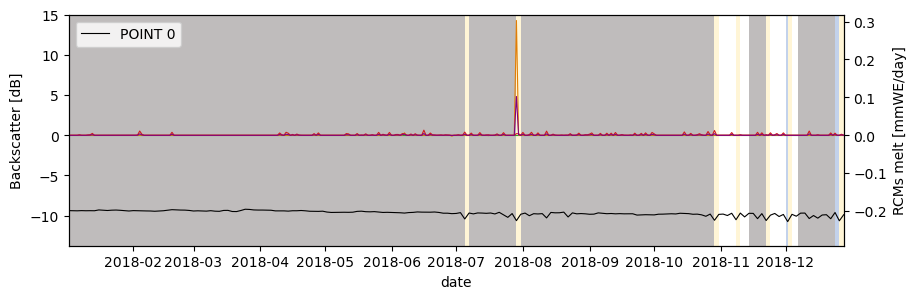

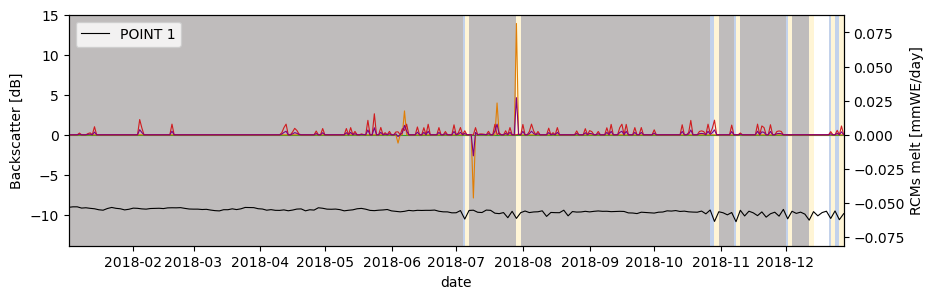

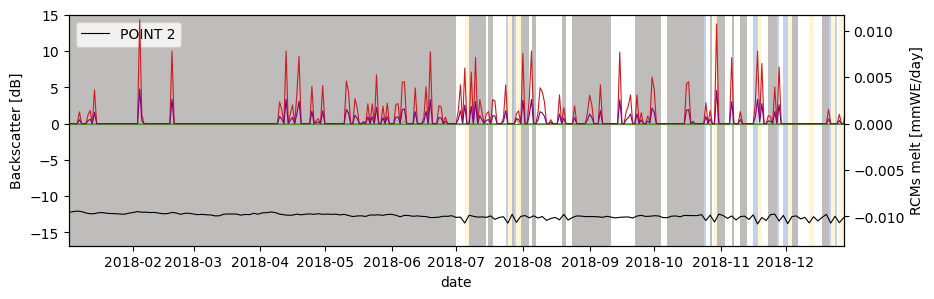

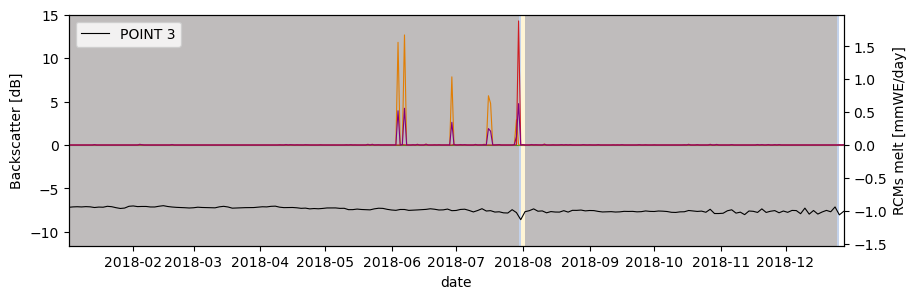

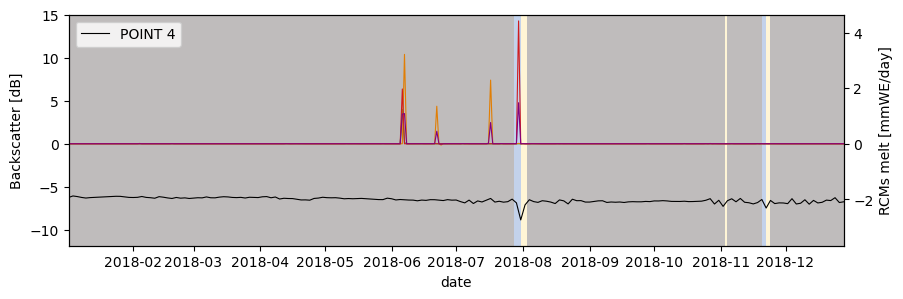

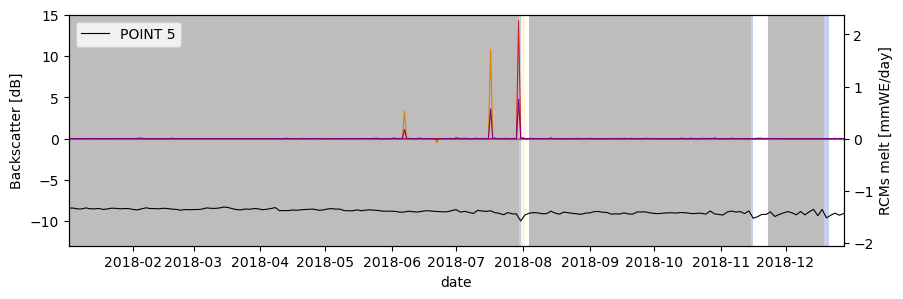

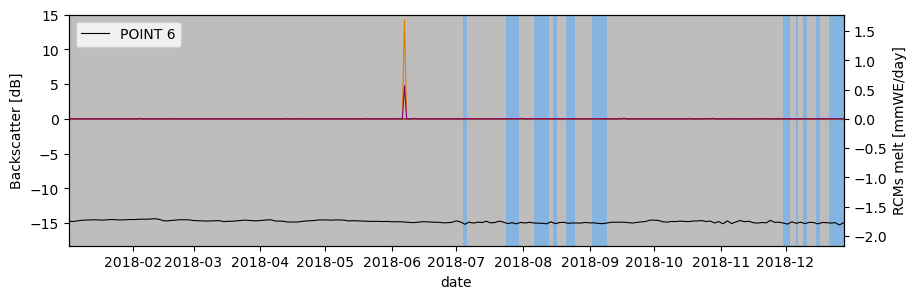

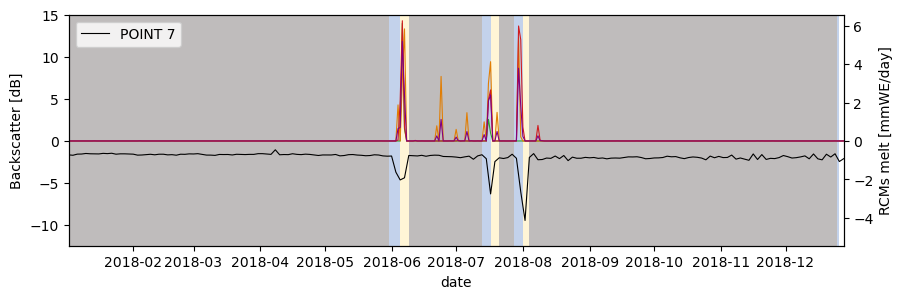

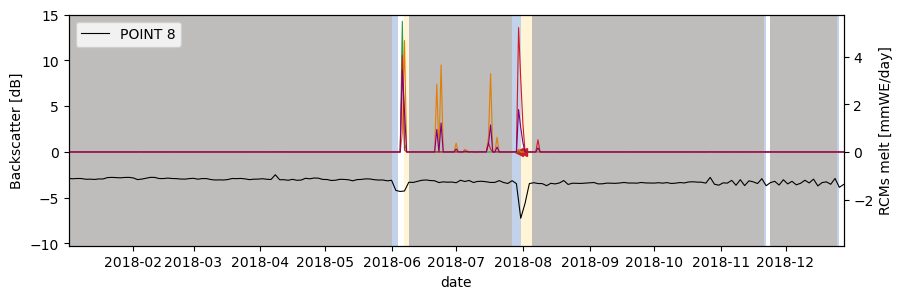

In [17]:
#selected_points = gpd.read_file('/home/annpug/Desktop/annpug/QGIS/selected_points.shp')
selected_points = gpd.read_file('/home/annpug/Desktop/annpug/QGIS/meltseason_2018_selected_points.shp')

#selected_points = gpd.read_file(shapefile_name)
#selected_points = gpd.read_file('/home/annpug/Desktop/annpug/flowline_2_highres.shp')
#selected_points["inv_dist"] = max(selected_points['distance']) - selected_points['distance']
#selected_points = selected_points.sort_values('inv_dist')
#selected_points = selected_points.reset_index(drop=True)

for p in range(0, len(selected_points)):
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    x_pixel = int((selected_points.geometry.x[p] - ul_x) / x_dist)
    y_pixel = -int((ul_y - selected_points.geometry.y[p]) / y_dist)
    #print(x_pixel,y_pixel)
    #plt.scatter(x_pixel,y_pixel)
    
    point_mar = mar[:, y_pixel,x_pixel]
    point_hirham = hirham[:,y_pixel,x_pixel]
    point_racmo = racmo[:,y_pixel,x_pixel]
    point_ens = ens_mean[:,y_pixel,x_pixel]
    dates_class, year_ASCAT, doys,res = lib.classify(data[:,y_pixel,x_pixel],dates,config['PROCESSING'])
    dates=np.asarray(dates)
    point_ascat = data[:,y_pixel,x_pixel]

    fig, ax = plt.subplots(1,figsize=(10, 3))
    
    for i,j in ct:
        z=0
        for k in dates_class[np.array(res==i)]:
            ax.axvspan(k,k +  np.timedelta64(24,'h'), facecolor=j, alpha=0.8)
            z+=1
    ax.plot(dates,point_ascat,'k-', label = f'POINT {p}', linewidth = 0.8) #,label=f'lat {lat} lon {lon}')
    #ax.plot(doys,res)
    ax.tick_params(labelsize=10)
    ax.set_xlabel('date')
    ax.set_ylabel('Backscatter [dB]')
    ax.set_ylim([min(point_ascat)-3, 15])
    #ax.set_ylim([-26, 15])
    #ax.set_title(f'Point {p+1}')
    axr = ax.twinx()
    #ascat_season = [dates_rcm[int(onset_ascat[y_pixel, x_pixel])], dates_rcm[int(end_ascat[y_pixel, x_pixel])]]
    
    try: 
        hirham_season = [dates_rcm[int(start_hirham[y_pixel, x_pixel])], dates_rcm[int(end_hirham[y_pixel, x_pixel])]]
        axr.plot(hirham_season, [0,0], '<', color = color_hirham)
    except ValueError:
        print(f'No start/end for Hirham for point {p+1}')
    
    try: 
        racmo_season = [dates_rcm[int(start_racmo[y_pixel, x_pixel])], dates_rcm[int(end_racmo[y_pixel, x_pixel])]]
        axr.plot(racmo_season, [0,0], '<', color = color_racmo)
    except ValueError:
        print(f'No start/end for Racmo for point {p+1}')
    
    try:  
        mar_season = [dates_rcm[int(start_mar[y_pixel, x_pixel])], dates_rcm[int(end_mar[y_pixel, x_pixel])]]
        axr.plot(mar_season, [0,0], '<', color = color_mar)     
    except ValueError:
        print(f'No start/end for Mar for point {p+1}')
    try: 
        ens_season = [dates_rcm[int(start_ens[y_pixel, x_pixel])], dates_rcm[int(end_ens[y_pixel, x_pixel])]]
        axr.plot(ens_season, [0,0], '<', color = 'purple')
    except ValueError:
        print(f'No start/end for Ensemble mean for point {p}')
    
        
    axr.plot(dates_rcm, point_hirham, color =color_hirham, label = 'HIRHAM', linewidth = 0.8)
    axr.plot(dates_rcm, point_mar, color =color_mar, label = 'MAR', linewidth = 0.8)
    axr.plot(dates_rcm, point_racmo, color =color_racmo, label = 'RACMO', linewidth = 0.8)
    axr.plot(dates_rcm, point_ens, color ='purple', label = 'Ensemble mean', linewidth = 0.8)
    #axr.plot(dates_ascat, ascat[:, y_pixel, x_pixel])
    #plt.plot(ascat_season, [0,0], '<', color = 'black')

    axr.set_ylabel('RCMs melt [mmWE/day]')
    axr.set_xlim(dates[0], dates[-1])
    #axr.set_ylim(-60, 60)


    # limit stuff:
    ax1_ylims = ax.axes.get_ylim()           # Find y-axis limits set by the plotter
    ax1_yratio = float(ax1_ylims[0] / ax1_ylims[1])  # Calculate ratio of lowest limit to highest limit
    ax2_ylims = axr.axes.get_ylim()           # Find y-axis limits set by the plotter
    ax2_yratio = float(ax2_ylims[0] / ax2_ylims[1])  # Calculate ratio of lowest limit to highest limit
    #ax.plot([dates[0],dates[-1]],[0,0],'k--') #,label=f'lat {lat} lon {lon}')

    if ax1_yratio < ax2_yratio: 
        axr.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
    else:
        ax.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)
    ax.legend(loc = 'upper left')
    fig.savefig(f'/home/annpug/Desktop/annpug/figures/{year}_profile_at_point_{p}.png')

In [ ]:

fig, axs = plt.subplots(1, 3, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})

#ax[0].imshow(onset_dif_ens, vmin = -30,vmax = 30, cmap = 'RdBu' )
#ax[1].imshow(end_dif_ens, vmin = -30,vmax = 30, cmap = 'RdBu')

#im = ax[2].imshow(duration_dif_ens, vmin = -30,vmax = 30, cmap = 'RdBu' )
#plt.colorbar(im , ax = ax[0], label = 'Duration of melt season [#Days]')
fig.suptitle('ASCAT - ensenble mean', fontweight = 'bold')


plot_greenland(onset_dif_ens, axs[0], crs_epsg, cbar = False,
               vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(end_dif_ens, axs[1], crs_epsg, cbar = False,
               vmin = minlim, vmax = maxlim, cmap = cmap)
plot_greenland(duration_dif_ens, axs[2], crs_epsg, cbar = True,  
               cbar_label = r'$\Delta$days', 
               vmin = minlim, vmax = maxlim, cmap = cmap)


for p in range(0, len(selected_points)):
    
    #ascat_season = [dates_rcm[int(onset_ascat[y_pixel, x_pixel])], dates_rcm[int(end_ascat[y_pixel, x_pixel])]]
    #hirham_season = [dates_rcm[int(start_hirham[y_pixel, x_pixel])], dates_rcm[int(end_hirham[y_pixel, x_pixel])]]
    #racmo_season = [dates_rcm[int(start_racmo[y_pixel, x_pixel])], dates_rcm[int(end_racmo[y_pixel, x_pixel])]]
    #mar_season = [dates_rcm[int(start_mar[y_pixel, x_pixel])], dates_rcm[int(end_mar[y_pixel, x_pixel])]]
    #ens_season = [dates_rcm[int(start_ens[y_pixel, x_pixel])], dates_rcm[int(end_ens[y_pixel, x_pixel])]]
    axs[0].scatter(selected_points.geometry.x[p], selected_points.geometry.y[p],facecolors='none', edgecolors='black')
    axs[0].annotate(f'{p+1}', (selected_points.geometry.x[p]+3e4, selected_points.geometry.y[p]), color = 'black', fontweight = 'bold')
    axs[1].scatter(selected_points.geometry.x[p], selected_points.geometry.y[p], facecolors='none', edgecolors='grey')
    axs[1].annotate(f'{p+1}', (selected_points.geometry.x[p]+3e4, selected_points.geometry.y[p]), color = 'grey', fontweight = 'bold')
    axs[2].scatter(selected_points.geometry.x[p], selected_points.geometry.y[p], facecolors='none', edgecolors='lightgrey')
    axs[2].annotate(f'{p+1}', (selected_points.geometry.x[p]+3e4, selected_points.geometry.y[p]), color = 'grey', fontweight = 'bold')
    
#fig.tight_layout(pad=-0)

# Backscatter along flowlines

Text(0.5, 1.0, 'Backscatter profiles along flowline 3')

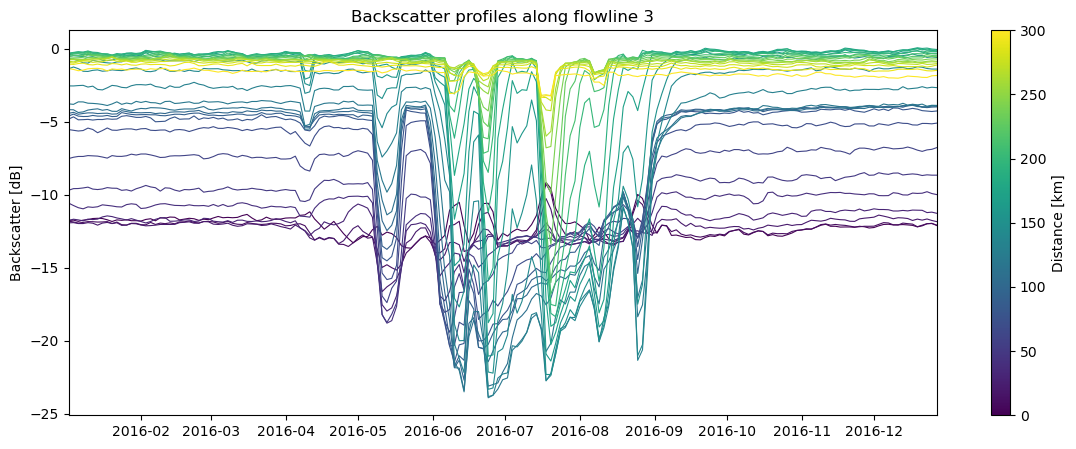

In [37]:
import matplotlib

fl_no = 3
shapefile_name = f'/home/annpug/Desktop/annpug/QGIS/flowline_{fl_no}_highres.shp'
selected_points = gpd.read_file(shapefile_name)
selected_points["inv_dist"] = max(selected_points['distance']) - selected_points['distance']
selected_points = selected_points.sort_values('inv_dist')
selected_points = selected_points.reset_index(drop=True)

# Get pixel index: 
ul_x= geo_matrix[0]
ul_y = geo_matrix[3]
x_dist = geo_matrix[1]
y_dist = geo_matrix[5]
x_pixel = ((selected_points.geometry.x - ul_x) / x_dist).astype(int)
y_pixel = -((ul_y - selected_points.geometry.y) / y_dist).astype(int)
selected_points['x_pixel'] = x_pixel 
selected_points['y_pixel'] = y_pixel 

#selected_points = selected_points.reset_index()
#selected_points.to_file(shapefile_name)


cmap=matplotlib.cm.viridis
colors = cmap(np.linspace(0,1,len(selected_points)))

fig, ax = plt.subplots(1,figsize=(14, 5))

#fig2, ax2 = plt.subplots(1,figsize=(4, 5.5),subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)}) 
#plot_greenland(onset_dif_ens,ax2, crs_epsg, cbar = False,
#               vmin = minlim, vmax = maxlim, cmap = cmap)

for p in range(0, len(selected_points)):
    point_ascat = data[:,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ax.plot(dates,point_ascat,'-', label = f'POINT {p+1}', linewidth = 0.8, color = colors[p]) #,label=f'lat {lat} lon {lon}')
    
    #ax2.scatter(selected_points.geometry.x[p], selected_points.geometry.y[p], facecolors='none', edgecolors='black', s = 10)
    #ax2.annotate(f'{p+1}', (selected_points.geometry.x[p]+3e4, selected_points.geometry.y[p]), color = 'black', fontweight = 'bold')
    
norm = plt.Normalize(0, max(selected_points['distance']/1000))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
sm.set_array([])
ax.figure.colorbar(sm, ax=ax, label = 'Distance [km]')  
ax.set_xlim(dates[0], dates[-1])
ax.set_ylabel('Backscatter [dB]')
ax.set_title(f'Backscatter profiles along flowline {fl_no}')
#ax2.set([200,0 , 200, 100])
#ax2.set_extent([-600000 ,-500000, -60000, -1400000],crs = cartopy.crs.NorthPolarStereo(central_longitude=0))



In [28]:
ascat_along_flowline= np.zeros((len(selected_points),10))
ascat_class = np.zeros((len(selected_points),10))
start_time = 90
dt = 3
for p in range(0, len(selected_points)):
    ascat_along_flowline[p,0] = data[start_time,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,1] = data[start_time+dt,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,2] = data[start_time+dt*2,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,3] = data[start_time+dt*3,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,4] = data[start_time+dt*4,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,5] = data[start_time+dt*5,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,6] = data[start_time+dt*6,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,7] = data[start_time+dt*7,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,8] = data[start_time+dt*8,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    ascat_along_flowline[p,9] = data[start_time+dt*9,selected_points.y_pixel[p],selected_points.x_pixel[p]]
    
    ascat_class[p, :] = np.array([ascat[dates[start_time].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]], 
                         ascat[dates[start_time+dt].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ascat[dates[start_time+dt*2].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ascat[dates[start_time+dt*3].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ascat[dates[start_time+dt*4].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ascat[dates[start_time+dt*5].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ascat[dates[start_time+dt*6].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ascat[dates[start_time+dt*7].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ascat[dates[start_time+dt*8].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ascat[dates[start_time+dt*9].timetuple().tm_yday, selected_points.y_pixel[p],selected_points.x_pixel[p]],
                         ]).astype(int)
    
    
    
dates4label = [dates[start_time], dates[start_time+dt], dates[start_time+dt*2],
               dates[start_time+dt*3], dates[start_time+dt*4], dates[start_time+dt*5], 
               dates[start_time+dt*6], dates[start_time+dt*7], dates[start_time+dt*8], dates[start_time+dt*9]]
dates4label = [d.date() for d in dates4label]

fig, ax = plt.subplots(1,figsize=(14, 5))
ax.plot(selected_points.inv_dist/1000, ascat_along_flowline,'-o',label = dates4label)#, label = f'POINT {p+1}', linewidth = 0.8, color = colors[p]) #,label=f'lat {lat} lon {lon}')
#ax.scatter(selected_points.inv_dist/1000, ascat_along_flowline)#, label = f'POINT {p+1}', linewidth = 0.8, color = colors[p]) #,label=f'lat {lat} lon {lon}')
ax.set_xlim(0,selected_points.inv_dist[p]/1000 )
ax.set_xlabel('Disatnce from outlet [km]')
ax.set_ylabel('Backscatter [dB]')
ax.set_title(f'Backscatter along flowline {fl_no}')
ax.legend()
plt.show()

AttributeError: 'GeoDataFrame' object has no attribute 'y_pixel'

# Number of meltdays 

/tmp/ipykernel_15549/4273480225.py:104: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_melt_match,sum_melt_ascat)*100


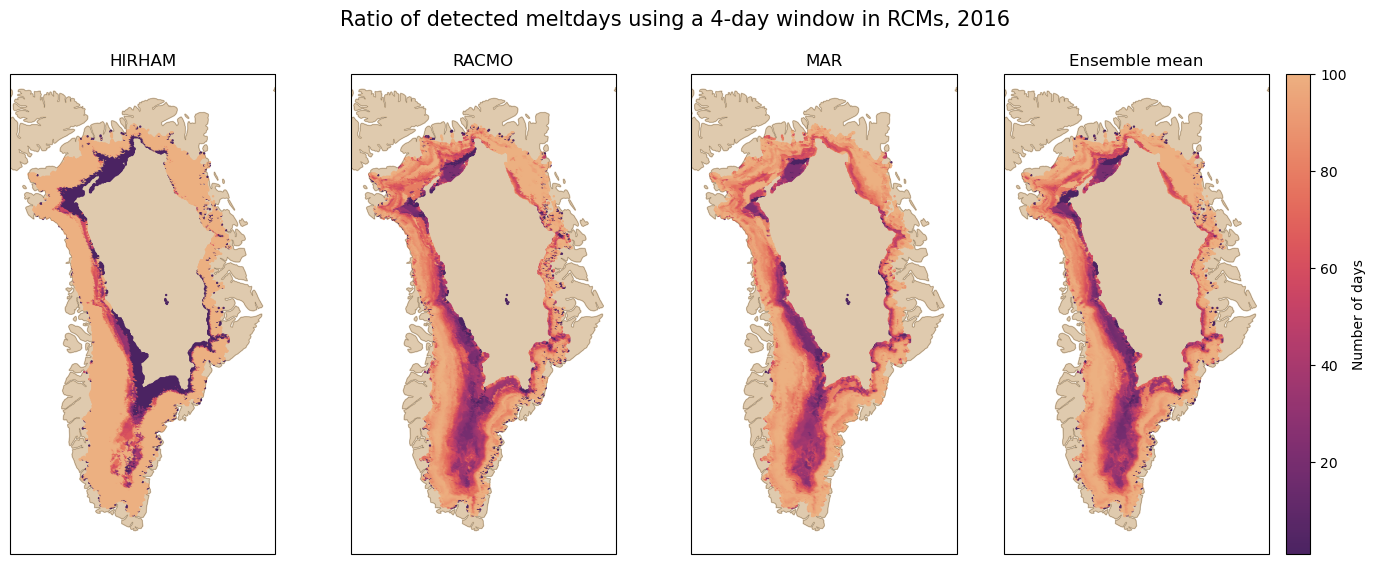

In [152]:
cmap = sns.color_palette("flare_r", as_cmap=True)
window = 4
melt_ascat = np.zeros(ascat.shape)
melt_ascat[(ascat >= 1) & (ascat <= 2)] = 1

match_hirham = window_comparion(melt_ascat, hirham, 1, window)
match_racmo = window_comparion(melt_ascat, racmo, 1,  window)
match_mar = window_comparion(melt_ascat, mar, 1, window)
match_ens = window_comparion(melt_ascat, ens_mean, 1, window)
                               
# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Ratio of detected meltdays using a {window}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_hirham, axs[0], crs_epsg, vmin = 0, vmax = 30,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_racmo, axs[1], crs_epsg,  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_mar, axs[2], crs_epsg,    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_ens, axs[3], crs_epsg,  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

/tmp/ipykernel_15549/4273480225.py:104: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_melt_match,sum_melt_ascat)*100


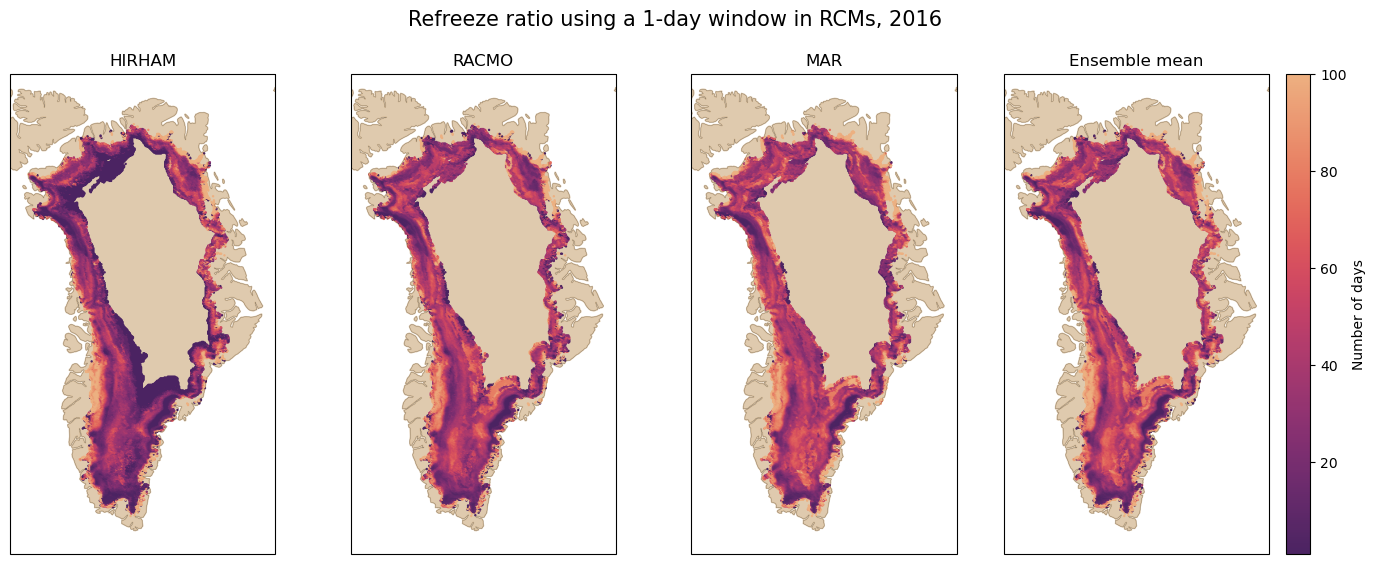

In [146]:
window_refreeze = 1
refreeze_ascat = np.zeros(ascat.shape)
refreeze_ascat[ascat == 3] = 1

match_refreeze_hirham = window_comparion(refreeze_ascat, hirham, 1, window_refreeze)
match_refreeze_racmo = window_comparion(refreeze_ascat, racmo, 1,  window_refreeze)
match_refreeze_mar = window_comparion(refreeze_ascat, mar, 1, window_refreeze)
match_refreeze_ens = window_comparion(refreeze_ascat, ens_mean, 1, window_refreeze)

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_refreeze_hirham, axs[0], crs_epsg, vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_refreeze_racmo, axs[1], crs_epsg,  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_refreeze_mar, axs[2], crs_epsg,    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_refreeze_ens, axs[3], crs_epsg,  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

In [149]:
end_refreeze = np.argwhere((refreeze_ascat[:-1,:,:] - refreeze_ascat[1:,:,:]) == 1)
sorted_end_indices = np.lexsort((end_refreeze[:, 2], end_refreeze [:, 1]))
end_refreeze = end_refreeze[sorted_end_indices]

start_refreeze = np.argwhere((refreeze_ascat[:-1,:,:] - refreeze_ascat[1:,:,:]) == -1)
sorted_start_indices = np.lexsort((start_refreeze[:, 2],start_refreeze [:, 1]))
start_refreeze = start_refreeze[sorted_start_indices]


intermidiate_refreeze_ascat = np.zeros(ascat.shape)
end_refreeze_ascat = np.zeros(ascat.shape) 

for i in range(len(end_refreeze)):
    ascat_after_refreeze = ascat[end_refreeze[i,0]+1:, end_refreeze[i,1], end_refreeze[i,2]]
    
    # If the melt is detected after refreezing; 
    if sum(ascat_after_refreeze) > 0: 
        intermidiate_refreeze_ascat[start_refreeze[i,0]+1:end_refreeze[i,0]+1,end_refreeze[i, 1], end_refreeze[i,2]] = 1
    # No melt class after refreezing: 
    if sum(ascat_after_refreeze) == 0: 
        end_refreeze_ascat[start_refreeze[i,0]+1:end_refreeze[i,0]+1,end_refreeze[i, 1], end_refreeze[i,2]] = 1


/tmp/ipykernel_15549/4273480225.py:104: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_melt_match,sum_melt_ascat)*100


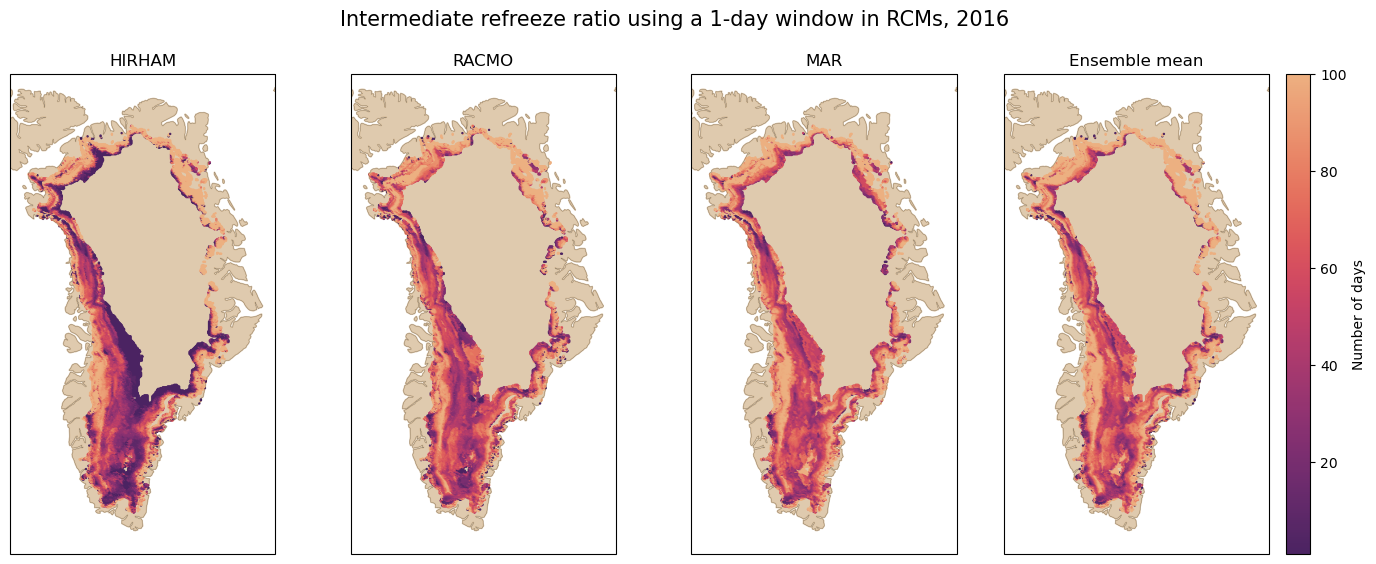

In [150]:
match_inter_refreeze_hirham = window_comparion(intermidiate_refreeze_ascat, hirham, 1, window_refreeze)
match_inter_refreeze_racmo = window_comparion(intermidiate_refreeze_ascat, racmo, 1,  window_refreeze)
match_inter_refreeze_mar = window_comparion(intermidiate_refreeze_ascat, mar, 1, window_refreeze)
match_inter_refreeze_ens = window_comparion(intermidiate_refreeze_ascat, ens_mean, 1, window_refreeze)    

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Intermediate refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_inter_refreeze_hirham, axs[0], crs_epsg, vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_inter_refreeze_racmo, axs[1], crs_epsg,  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_inter_refreeze_mar, axs[2], crs_epsg,    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_inter_refreeze_ens, axs[3], crs_epsg,  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

/tmp/ipykernel_15549/4273480225.py:104: RuntimeWarning: invalid value encountered in divide
  return np.divide(sum_melt_match,sum_melt_ascat)*100


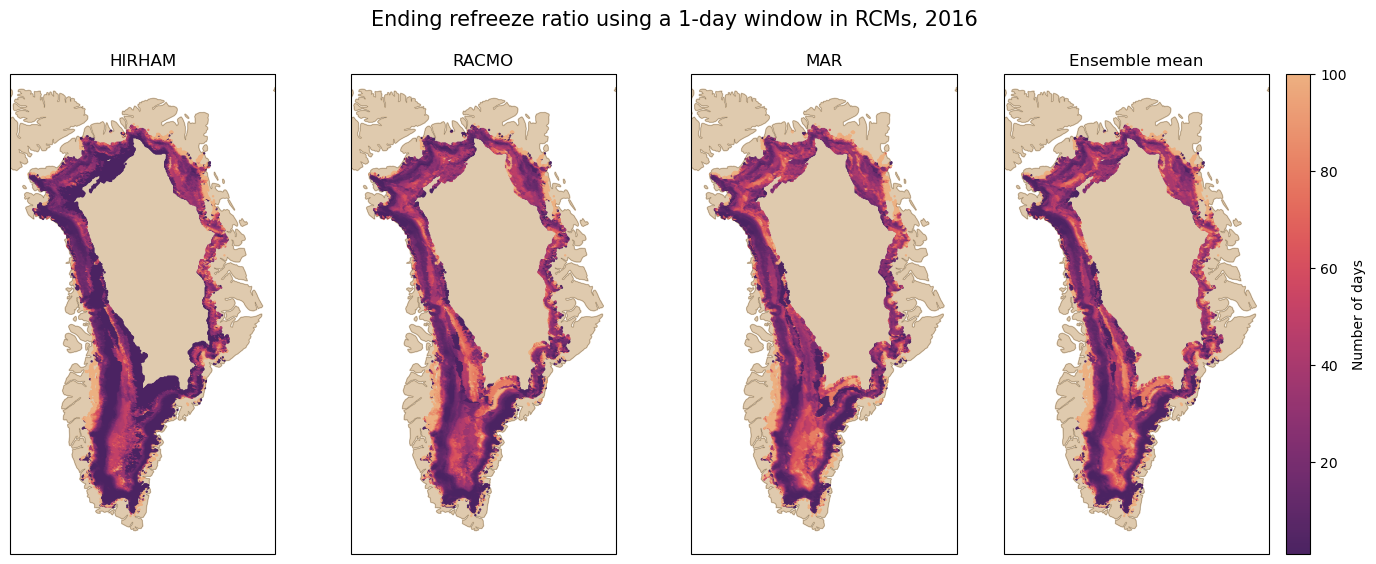

In [151]:
match_end_refreeze_hirham = window_comparion(end_refreeze_ascat, hirham, 1, window_refreeze)
match_end_refreeze_racmo = window_comparion(end_refreeze_ascat, racmo, 1,  window_refreeze)
match_end_refreeze_mar = window_comparion(end_refreeze_ascat, mar, 1, window_refreeze)
match_end_refreeze_ens = window_comparion(end_refreeze_ascat, ens_mean, 1, window_refreeze)    

# Plot
fig, axs = plt.subplots(1, 4, figsize = (14,5.5), subplot_kw={'projection': cartopy.crs.NorthPolarStereo(central_longitude=-45)})
fig.suptitle(f'Ending refreeze ratio using a {window_refreeze}-day window in RCMs, {year}\n\n', fontsize = 15)
plot_greenland(match_end_refreeze_hirham, axs[0], crs_epsg, vmin = 0, vmax = 100,  cmap=cmap)
axs[0].set_title('HIRHAM')
plot_greenland(match_end_refreeze_racmo, axs[1], crs_epsg,  vmin = 0, vmax = 100, cmap=cmap)
axs[1].set_title('RACMO')
plot_greenland(match_end_refreeze_mar, axs[2], crs_epsg,    vmin = 0, vmax = 100, cmap=cmap)
axs[2].set_title('MAR')
plot_greenland(match_end_refreeze_ens, axs[3], crs_epsg,  cbar = True,  
               cbar_label = f'Number of days', 
               vmin = 1, vmax = 100, cmap=cmap)
axs[3].set_title('Ensemble mean')
fig.tight_layout(pad = -0.4)
plt.show()

In [153]:

write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_hirham_melt_days_{year}.tif",  match_hirham.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_racmo_melt_days_{year}.tif", match_racmo.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_mar_melt_days_{year}.tif", match_mar.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_ens_melt_days_{year}.tif", match_ens.astype('float32'), ds)

write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_hirham_end_refreezing_days_{year}.tif", match_end_refreeze_hirham.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_racmo_end_refreezing_days_{year}.tif", match_end_refreeze_racmo.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_mar_end_refreezing_days_{year}.tif", match_end_refreeze_mar.astype('float32'), ds)
write_geotiff(f"/home/annpug/Desktop/annpug/difference_maps/ASCAT_ens_end_refreezing_days_{year}.tif", match_end_refreeze_ens.astype('float32'), ds)
